* Investigate why Froude No not work. Example shows the snapshot of Froude number over the whole plume region with upper layer reaching 10 m of May results.

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (nc_tools,viz_tools,tidetools)
import matplotlib.pyplot as plt
import StraTimeSeries as sts
import R_mixStuff as RS
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
%matplotlib inline

In [2]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][:, :]
Y = grid6.variables['nav_lat'][:, :]
bathy = grid6.variables['Bathymetry'][:, :]
## tmask
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
tmask = mesh.variables['tmask'][0,:,380:510,240:397]
np_mask = np.abs(1-tmask) 
e3t = mesh.variables['e3t'][0,:,380:510,240:397]

In [3]:
## May results
all_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_T.nc','r')
all_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_U.nc','r')
all_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_V.nc','r')
lon = all_T.variables['nav_lon']
lat = all_T.variables['nav_lat']

In [4]:
def calculate_density(t, s):
    """Caluclates the density given temperature in deg C (t)
    and salinity in psu (s).

    returns the density as an array (rho)
    """
    rho = (
        999.842594 + 6.793952e-2 * t
        - 9.095290e-3 * t*t + 1.001685e-4 * t*t*t
        - 1.120083e-6 * t*t*t*t + 6.536332e-9 * t*t*t*t*t
        + 8.24493e-1 * s - 4.0899e-3 * t*s
        + 7.6438e-5 * t*t*s - 8.2467e-7 * t*t*t*s
        + 5.3875e-9 * t*t*t*t*s - 5.72466e-3 * s**1.5
        + 1.0227e-4 * t*s**1.5 - 1.6546e-6 * t*t*s**1.5
        + 4.8314e-4 * s*s)
    return rho

In [5]:
def calculate_reducedGravity(t,s,u,time,ssh,dep,dep_ind):
    """Calculate g', which is g*deltaRho/Rho0 = g(1-integral(Rhodz)/integral(dz))/Rho0)
    Here Rho0 = 1035, g= 9.80665"""
    rho = calculate_density(t,s)
    # acceleration due to gravity
    g = 9.80665
    rho0=1023 #NEMO fvalue in kg/m^3
    change = np.zeros(u.shape);
    change_dep = np.zeros(u.shape)
    for z in np.arange(dep_ind):
        adj_ssh = 1+ssh[time]/np.sum(e3t[:]*tmask[:],axis = 0)
        change[z] = rho[z,1:,1:]*e3t[z,1:,1:]*adj_ssh[1:,1:]*tmask[z,1:,1:]
        change_dep[z] = e3t[z,1:,1:]*adj_ssh[1:,1:]*tmask[z,1:,1:]
    change = np.nansum(change,axis = 0)
    change_dep = np.nansum(change_dep,axis = 0)
    g_prime = g*(1-change/(rho0*change_dep))

    return g_prime

* $Fr = \frac{u}{\sqrt{g^{'}h}}$, where u is the weighted total velocity of upper layer $\frac{\int\Delta\rho\sqrt{u^2+v^2}dz}{\int\Delta\rho dz}$, here $\Delta\rho$ is the density difference between lower layer and this layer,  $g^{'} = g\frac{\Delta \rho}{\rho_{0}}$, $\Delta\rho = \rho_{0} - \frac{\int\rho dz}{\int dz}$, where both numerator and denominator take into account ssh variation.

In [19]:
def Fr_No(grid_T,grid_U,grid_V,t,dep_ind,ti):
    """This function was made to calculate the Froude number 
    defined above """
    u = {};v = {};to_speed = {}; to_speed_inte = {};rho_inte = {};ssh = {};T={};S={};g_prime = {};Fr = {};
    u[ti] = grid_U.variables['vozocrtx']
    v[ti] = grid_V.variables['vomecrty']
    u[ti],v[ti] = viz_tools.unstagger(u[ti][t,0:dep_ind],v[ti][t,0:dep_ind])
    
    to_speed[ti] = np.sqrt(u[ti]**2+v[ti]**2)
    to_speed_inte[ti] = np.zeros(u[ti].shape)
    rho_inte[ti] = np.zeros(u[ti].shape)
    ssh[ti] = grid_T.variables['sossheig']
    T[ti] = grid_T.variables['votemper'][t] ## to calculate rho
    T[ti] = np.ma.masked_array(T[ti],mask = np_mask) ## mask 0 values, very important!!! Or density integral is negative sometimes
    S[ti] = grid_T.variables['vosaline'][t]
    S[ti] = np.ma.masked_array(S[ti],mask= np_mask)
    dep = grid_T.variables['deptht']
    rho = calculate_density(T[ti],S[ti])
    
    for z in np.arange(dep_ind):
        adj_ssh = 1+ssh[ti][t]/np.sum(e3t[:]*tmask[:],axis = 0)
        to_speed_inte[ti][z] = to_speed[ti][z]*e3t[z,1:,1:]*adj_ssh[1:,1:]*tmask[z,1:,1:]*(1023-rho[z,1:,1:]) 
        rho_inte[ti][z] = e3t[z,1:,1:]*adj_ssh[1:,1:]*tmask[z,1:,1:]*(1023-rho[z,1:,1:])
            
    to_speed_inte[ti] = np.nansum(to_speed_inte[ti],axis = 0)
    rho_inte[ti] = np.nansum(rho_inte[ti],axis = 0)
    g_prime[ti] = calculate_reducedGravity(T[ti],S[ti],u[ti],t,ssh[ti],dep,dep_ind)
    Fr[ti] =to_speed_inte[ti]/(np.sqrt(g_prime[ti]*dep[dep_ind])*rho_inte[ti]) ##Fr 
    return Fr,to_speed_inte,rho_inte,g_prime

In [20]:
def plot_spatial(grid_T,grid_U,grid_V,t,dep_ind,ti,levels,lonmax,lonmin,latmax,latmin,flag):
    """Spatial plot of Fr number if flag = 'Fr', baroclinic velocity if flag = 'baroclinic',
    internal wave speed if flag = 'internal'"""
    Fr,to_speed_inte,rho_inte,g_prime= Fr_No(grid_T,grid_U,grid_V,t,dep_ind,ti)
    dep = grid_T.variables['deptht']
    fig,ax = plt.subplots(1,1,figsize = (8,5))
    ## below are time averaged variable
    if flag =='Fr': ## 
        snapshot = Fr[ti]
        string = 'Froude Number'
    elif flag =='momentum':
        snapshot = to_speed_inte[ti]/rho_inte[ti]
        string = 'momentum [m/s]'
    elif flag == 'internal':
        snapshot = np.sqrt(g_prime[ti]*dep[dep_ind])
        string = 'Internal wave speed [m/s]'
    CS = ax.contourf(lon[1:,1:],lat[1:,1:],snapshot,levels,cmap = 'jet',extend='both')
    CS2 = ax.contour(CS, colors = 'k',hold='on',linewidths=(2,))
    cbar = fig.colorbar(CS,ax = ax)
    cbar.add_lines(CS2)
    cbar.set_label(string)
    viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
    viz_tools.plot_coastline(ax, grid6, coords = 'map')
    ax.set_xlim([lonmin,lonmax])
    ax.set_ylim([latmin,latmax])
    return snapshot

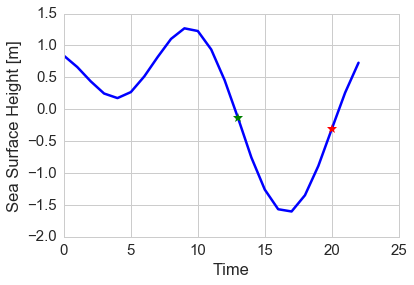

In [27]:
ssh = all_T.variables['sossheig']
plt.plot(ssh[-23:,86,89],'-b')
plt.plot(13,ssh[734,86,89],'g*',markersize = 10)
plt.plot(20,ssh[741,86,89],'r*',markersize = 10)
plt.ylabel('Sea Surface Height [m]')
plt.xlabel('Time')

# Depth 10m

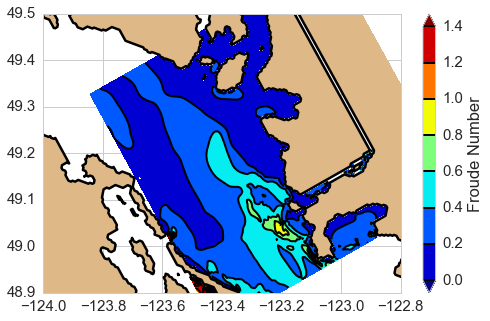

In [10]:
## peak flood tide Fr number
levels = [0,0.2,0.4,0.6,0.8,1,1.2,1.4]
Fr = plot_spatial(all_T,all_U,all_V,741,10,'all',levels,-122.8,-124.,49.5,48.9,'Fr')

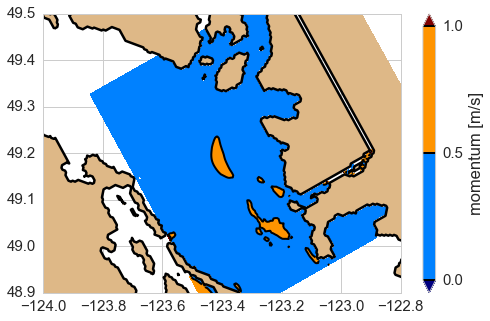

In [25]:
## peak flood tide momentum 
levels = [0,0.5,1]
tospeed = plot_spatial(all_T,all_U,all_V,741,10,'all',levels,-122.8,-124.,49.5,48.9,'momentum')

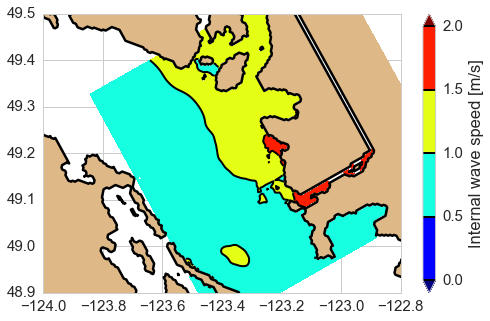

In [26]:
## peak flood tide internal wave speed
levels = [0,0.5,1,1.5,2]
iws = plot_spatial(all_T,all_U,all_V,741,10,'all',levels,-122.8,-124.,49.5,48.9,'internal')

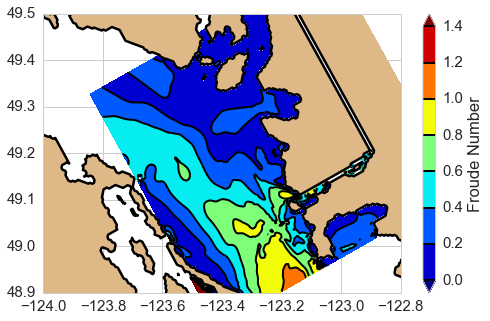

In [15]:
## peak ebb tide Fr number
levels = [0,0.2,0.4,0.6,0.8,1,1.2,1.4]
Fr = plot_spatial(all_T,all_U,all_V,734,10,'all',levels,-122.8,-124.,49.5,48.9,'Fr')

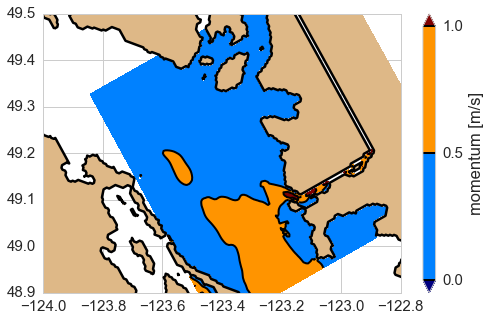

In [16]:
## peak ebb tide momentum 
levels = [0,0.5,1]
tospeed = plot_spatial(all_T,all_U,all_V,734,10,'all',levels,-122.8,-124.,49.5,48.9,'momentum')

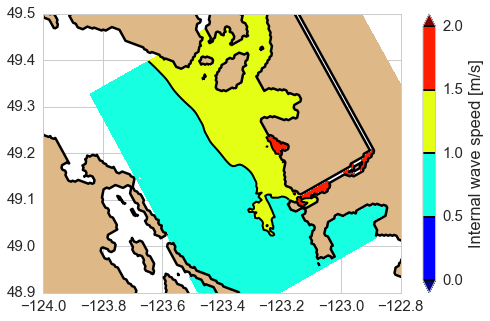

In [24]:
## peak ebb tide internal wave speed
levels = [0,0.5,1,1.5,2]
iws = plot_spatial(all_T,all_U,all_V,734,10,'all',levels,-122.8,-124.,49.5,48.9,'internal')

* Peak ebb: momentum southward (river outflow + ebb tides) dominant, buoyancy dominant in the river and northward of mouth (other river sources + Coriolis force?), indicating already mixed southward water.
* Peak flood: momentum weak, buoyancy forcing goes northward, suggesting subcritical flows.

# Dep 4 m

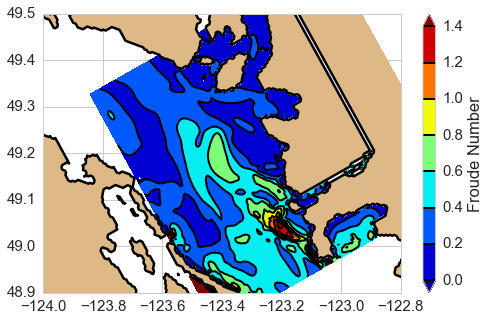

In [28]:
## peak flood tide Fr number
levels = [0,0.2,0.4,0.6,0.8,1,1.2,1.4]
Fr = plot_spatial(all_T,all_U,all_V,741,4,'all',levels,-122.8,-124.,49.5,48.9,'Fr')

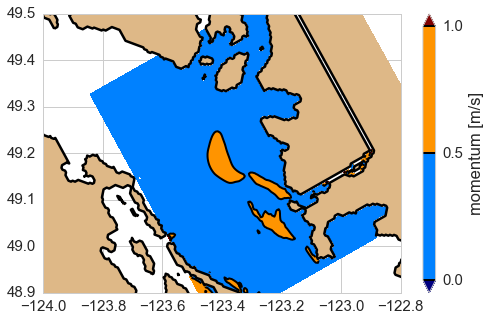

In [29]:
## peak flood tide momentum 
levels = [0,0.5,1]
tospeed = plot_spatial(all_T,all_U,all_V,741,4,'all',levels,-122.8,-124.,49.5,48.9,'momentum')

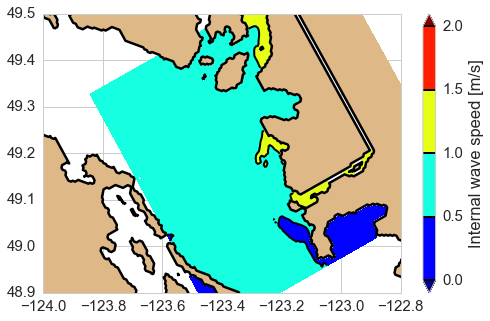

In [30]:
## peak flood tide internal wave speed
levels = [0,0.5,1,1.5,2]
iws = plot_spatial(all_T,all_U,all_V,741,4,'all',levels,-122.8,-124.,49.5,48.9,'internal')

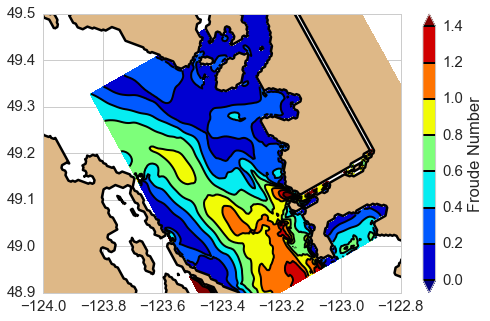

In [31]:
## peak ebb tide Fr number
levels = [0,0.2,0.4,0.6,0.8,1,1.2,1.4]
Fr = plot_spatial(all_T,all_U,all_V,734,4,'all',levels,-122.8,-124.,49.5,48.9,'Fr')

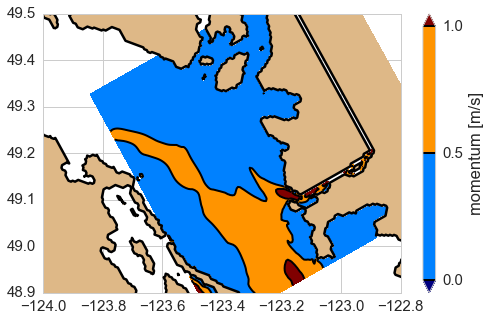

In [32]:
## peak ebb tide momentum 
levels = [0,0.5,1]
tospeed = plot_spatial(all_T,all_U,all_V,734,4,'all',levels,-122.8,-124.,49.5,48.9,'momentum')

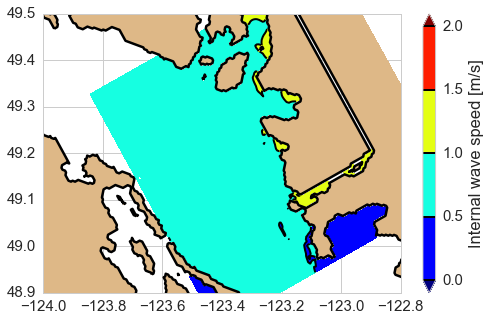

In [33]:
## peak ebb tide internal wave speed
levels = [0,0.5,1,1.5,2]
iws = plot_spatial(all_T,all_U,all_V,734,4,'all',levels,-122.8,-124.,49.5,48.9,'internal')